# Imports

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
import noisereduce as nr
import matplotlib.pyplot as plt
import seaborn as sns

import shutil
from pathlib import Path

# Config

In [ ]:
from config import run_config, DATA_DIR, AUDIO_PATH

run_config()

# Helper Functions

In [ ]:
def plot_feature_distributions(X, y, feature_names, selected_features):
    df = pd.DataFrame(X, columns=feature_names)
    df['label'] = y

    for feature in selected_features:
        plt.figure(figsize=(6, 4))
        sns.kdeplot(data=df, x=feature, hue='label', fill=True, common_norm=False, alpha=0.5)
        plt.title(f'Distribution of {feature} by Class')
        plt.grid(True)
        plt.show()

In [ ]:
def plot_feature_samples(X, y, feature_slices):
    n_classes = len(np.unique(y))
    n_features = len(feature_slices)

    fig, axs = plt.subplots(n_features, n_classes, figsize=(4 * n_classes, 3 * n_features), squeeze=False)
    fig.suptitle('Representative Feature Profiles per Class', fontsize=18, y=1.02)

    for i, (feat_name, feat_slice) in enumerate(feature_slices.items()):
        for cls in range(n_classes):
            ax = axs[i, cls]
            # pick one sample of this class
            idx = np.where(y == cls)[0][0]  # first sample from this class
            values = X[idx][feat_slice]

            if len(values) == 1:
                ax.bar([feat_name], values)
            else:
                ax.plot(values, marker='o')
            ax.set_title(f"{feat_name} | Class {cls}")
            ax.set_xticks(range(len(values)))
            ax.grid(True)

    plt.tight_layout()
    plt.show()


# Load Data

In [ ]:
df = pd.read_csv(DATA_DIR / "filtered_data_labeled.tsv", sep='\t')
df.head()

In [ ]:
df[df['path'].str.contains('.wav')].describe()

: 

In [ ]:
def copy_samples_to_folder(df, audio_path, destination_folder):
    # Select 20 audio files from the DataFrame
    selected_files = df.groupby('label').head(5)[['path', 'label']]  # Select 5 files from each class (label)

    # Create the destination folder if it doesn't exist
    destination_folder.mkdir(parents=True, exist_ok=True)

    # Copy the files
    for i, (_, row) in enumerate(selected_files.iterrows()):
        file_path = row['path']
        label = row['label']
        print(f"Copying {i+1}/{len(selected_files)}: {file_path}")
        file_path = os.path.join(audio_path, file_path)
        if os.path.exists(file_path):  # Check if the file exists
            destination_file = destination_folder / f"{i+1}.{file_path.split('.')[-1]}"
            shutil.copy(file_path, destination_file)
            print(f"Copied: {file_path} -> {destination_folder} as {destination_file.name}")
        else:
            print(f"File not found: {file_path}")

    selected_df_labels = selected_files['label']
    selected_df_labels = selected_df_labels.reset_index(drop=True)
    selected_df_labels.to_csv(destination_folder / "labels.tsv", sep='\t', index=False, header=False)

# # Define the destination folder
# destination_folder = Path("data/sampled_audio")
# copy_samples_to_folder(df, AUDIO_PATH, destination_folder)

Copying 1/20: common_voice_en_19687170.mp3
Copied: data\audios\common_voice_en_19687170.mp3 -> data\data_20_files as 1.mp3
Copying 2/20: common_voice_en_19687171.mp3
Copied: data\audios\common_voice_en_19687171.mp3 -> data\data_20_files as 2.mp3
Copying 3/20: common_voice_en_19687172.mp3
Copied: data\audios\common_voice_en_19687172.mp3 -> data\data_20_files as 3.mp3
Copying 4/20: common_voice_en_19687173.mp3
Copied: data\audios\common_voice_en_19687173.mp3 -> data\data_20_files as 4.mp3
Copying 5/20: common_voice_en_19687174.mp3
Copied: data\audios\common_voice_en_19687174.mp3 -> data\data_20_files as 5.mp3
Copying 6/20: common_voice_en_529569.mp3
Copied: data\audios\common_voice_en_529569.mp3 -> data\data_20_files as 6.mp3
Copying 7/20: common_voice_en_529573.mp3
Copied: data\audios\common_voice_en_529573.mp3 -> data\data_20_files as 7.mp3
Copying 8/20: common_voice_en_18421093.mp3
Copied: data\audios\common_voice_en_18421093.mp3 -> data\data_20_files as 8.mp3
Copying 9/20: common_voi

# Encoded Label Explanation

In [4]:
decoded_labels =  df.drop_duplicates(subset=['label'])[['label', 'age', 'gender']]\
                    .sort_values(by='label', ignore_index=True)\
                    .set_index('label')
decoded_labels

,age,gender
label,,
0,twenties,male
1,twenties,female
2,fifties,male
3,fifties,female


# Check Data Imbalance

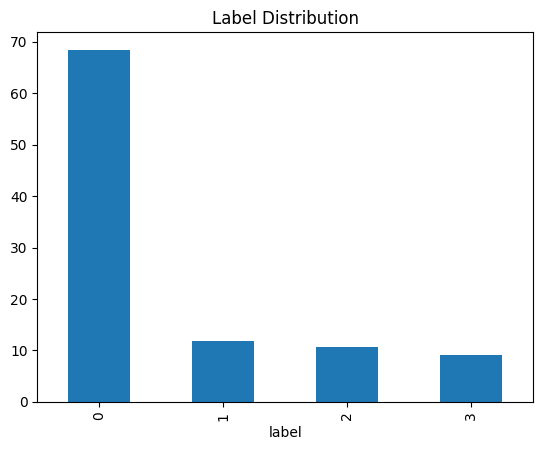

In [5]:
(df['label'].value_counts() / df.shape[0] * 100).plot(kind='bar', title='Label Distribution');

# Age & Gender Variety

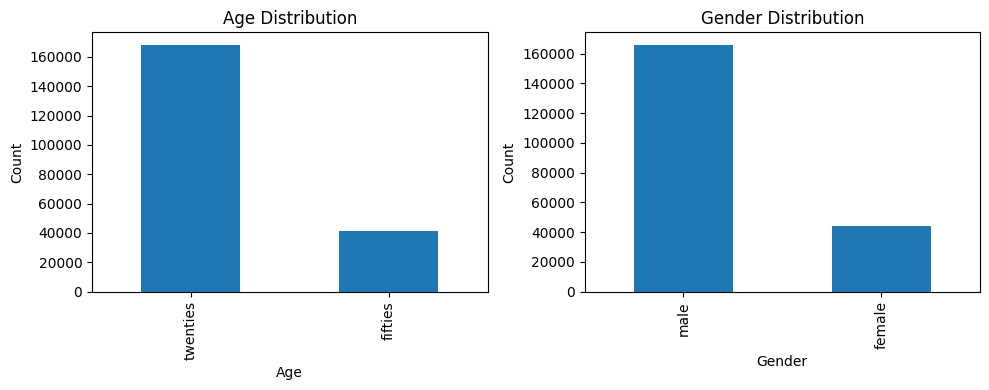

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.ravel()

for i, key in enumerate(['age', 'gender']):
    df[key].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{key.capitalize()} Distribution')
    axes[i].set_xlabel(key.capitalize())
    axes[i].set_ylabel('Count')

plt.tight_layout()

# Accent Variety

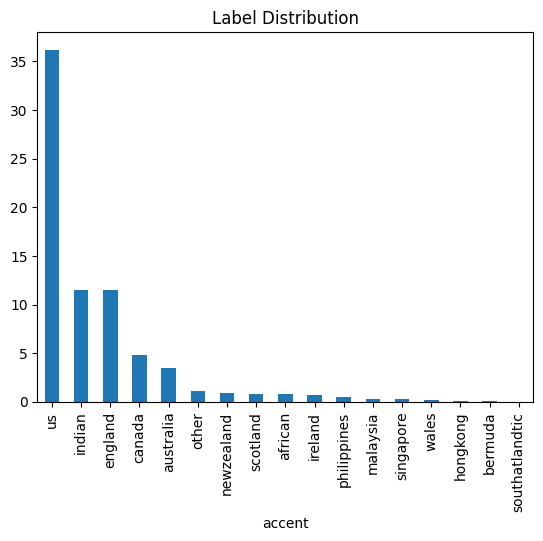

In [7]:
(df['accent'].value_counts() / df.shape[0] * 100).plot(kind='bar', title='Label Distribution');

# Sentence Length

(count    209791.000000
 mean          9.001082
 std           3.456210
 min           1.000000
 25%           6.000000
 50%           9.000000
 75%          12.000000
 max          40.000000
 Name: length, dtype: float64,
 <Axes: title={'center': 'Sentence Length Distribution'}, ylabel='Frequency'>)

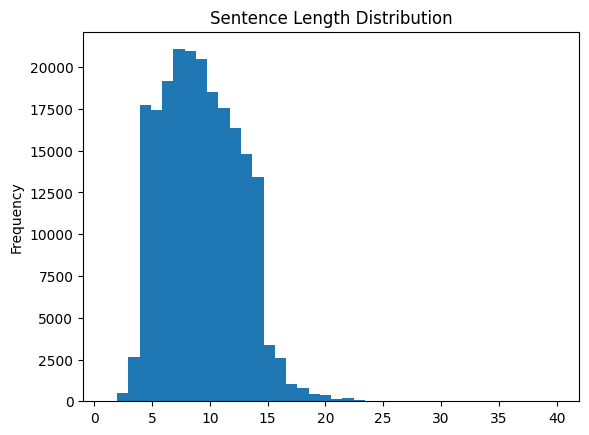

In [23]:
df['length'] = df['sentence'].str.split().apply(len)
df['length'].describe(), df['length'].plot(kind='hist', bins=40, title='Sentence Length Distribution')

In [25]:
df[df['sentence'].str.split().apply(len) == 1].shape

(45, 10)

# Features

In [ ]:
import librosa.display

def visualize_traditional_features(features: dict, sr: int = 16000):
    plt.figure(figsize=(12, 16))

    # MFCC
    plt.subplot(5, 1, 1)
    librosa.display.specshow(features["mfcc"], x_axis='time', sr=sr)
    plt.colorbar()
    plt.title('MFCC')

    # Chroma
    plt.subplot(5, 1, 2)
    librosa.display.specshow(features["chroma"], x_axis='time', y_axis='chroma', sr=sr)
    plt.colorbar()
    plt.title('Chroma')

    # Spectral Contrast
    plt.subplot(5, 1, 3)
    librosa.display.specshow(features["contrast"], x_axis='time', sr=sr)
    plt.colorbar()
    plt.title('Spectral Contrast')

    # F0 (Pitch)
    plt.subplot(5, 1, 4)
    f0 = features["f0"]
    times_f0 = librosa.times_like(f0, sr=sr)
    plt.plot(times_f0, f0, color='green')
    plt.title('Pitch (F0)')
    plt.ylabel('Hz')
    plt.xlabel('Time (s)')

    # ZCR
    plt.subplot(5, 1, 5)
    zcr = features["zcr"]
    plt.plot(librosa.times_like(zcr, sr=sr), zcr[0], color='purple')
    plt.title('Zero-Crossing Rate')
    plt.xlabel('Time (s)')

    plt.tight_layout()
    plt.show()

    # Print diagnostics
    print("Formants (Hz):", features["formants"])
    print(f"Duration statistics (s): mean = {features['dur_mean']:.2f}, std = {features['dur_std']:.2f}, segments = {features['dur_count']}")


In [ ]:
# Example index mapping
feature_slices_v2 = {
    "MFCC": slice(0, 20),                # 20 MFCCs
    "Chroma": slice(20, 32),             # 12 chroma
    "Contrast": slice(32, 39),           # 7 contrast bands
    "RMS": slice(39, 40),                # 1 value
    "ZCR": slice(40, 41),                # 1 value
    "Centroid": slice(41, 42),           # 1 value
    "F0": slice(42, 45),                 # mean, std, max
    "Loudness": slice(45, 47),           # mean, std
    "Duration": slice(47, 50),           # mean, std, count
    "Formants": slice(50, 54)            # f1_mean, f1_std, f2_mean, f2_std
}

feature_slices_v3 = {
    "MFCC": slice(0, 20),                # 20 MFCCs
    "Chroma": slice(20, 32),             # 12 chroma
    "Contrast": slice(32, 39),           # 7 contrast bands
    "RMS": slice(39, 40),                # 1 value
    "ZCR": slice(40, 41),                # 1 value
    "Centroid": slice(41, 42),           # 1 value
    "F0": slice(42, 45),                 # mean, std, max
    "Loudness": slice(45, 47),           # mean, std
    "Duration": slice(47, 50),           # mean, std, count
    "Formants": slice(50, 54)            # f1_mean, f1_std, f2_mean, f2_std
}

In [ ]:
from modules.feature_extraction import FeatureExtractor
extractor = FeatureExtractor()
X, y = extractor.load_cached_features("traditional", version=2)

In [ ]:
plot_feature_samples(X, y, feature_slices_v2)